# Acquiring All Papers into a Processed Array

In [1]:
!pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184505 sha256=2fc1eca80692b321d56bf9c6abdf345b56bc420acc078f15eb7364550dabe692
  Stored in directory: /root/.cache/pip/wheels/83/8b/7c/09ae60c42c7ba4ed2dddaf2b8b9186cb105255856d6ed3dba5
Successfully built python-docx


In [2]:
!pip install glove_python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement glove_python-binary (from versions: none)
ERROR: No matching distribution found for glove_python-binary


In [3]:
from docx import Document
import nltk
nltk.download('punkt')
import re
from nltk import sent_tokenize
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
import pickle
import numpy as np
import glob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from nltk.stem import WordNetLemmatizer
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
!git clone 'https://github.com/igorbrigadir/stopwords.git'

Cloning into 'stopwords'...
remote: Enumerating objects: 149, done.
remote: Total 149 (delta 0), reused 0 (delta 0), pack-reused 149
Receiving objects: 100% (149/149), 85.27 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [6]:
alir3z4_data = '/content/stopwords/en/alir3z4.txt'

more_stops = pd.read_csv('/content/stopwords/en/alir3z4.txt')
new_stops = list(more_stops["'ll"])

In [7]:
DOMAIN_STOPS = {'pubmed', 'et', 'al', 'page'}
STOPWORDS =  set(stopwords.words('english') + stopwords.words('german') +  stopwords.words('dutch') + stopwords.words('french') +  stopwords.words('spanish')  + new_stops) | DOMAIN_STOPS
STOPWORDS = set(STOPWORDS)

In [8]:
len(STOPWORDS)

2011

In [9]:
'a' in STOPWORDS

True

In [10]:
ROOT = "/content/drive/MyDrive/regen_x"

In [11]:
def get_docx(file_path):
    doc = []
    for para in Document(file_path).paragraphs:
        if para.text == "":
            continue
        doc += (sent_tokenize(para.text.lower())) # we lower text here
    return doc


def get_start_stop():
    domain_stops = {'pubmed', 'et', 'al', 'page'}
    with open('/content/stopwords/en/alir3z4.txt', 'r') as fn:
        new_stops = [line.strip() for line in fn.readlines()]
    STOPWORDS =  set(stopwords.words('english') + stopwords.words('german') +  stopwords.words('dutch') + stopwords.words('french') +  stopwords.words('spanish')  + new_stops) | domain_stops

    fn = glob.glob(ROOT + '/data/start-words/*')
    ALL_STARTS = [pickle.load(open(f , 'rb')) for f in fn]
    STARTWORDS = {}
    for f in ALL_STARTS:
      STARTWORDS.update(f)
    STARTWORDS = set(STARTWORDS.keys())

    assert(type(STOPWORDS)==set and type(STARTWORDS)==set)
    return (STARTWORDS, STOPWORDS)

In [12]:
STARTWORDS, STOPWORDS = get_start_stop()

In [13]:
from gensim.models import Word2Vec

In [14]:
from natsort import natsorted
import os

In [15]:
ROOT = "/content/drive/MyDrive/regen_x"

In [16]:
# for lemmatization 
import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [17]:
def do_lemmatizing(filtered):
  # convert list to string 
  spacy_parsed_text = nlp(" ".join(filtered)) 
  # Get the lemma for each token in the parsed text 
  
  # I wanted to keep pronouns so not taking lemma if it's a pronoun but if you want to remove pronouns use below commented line 
  # return " ".join([token.lemma_ for token in doc])

  # return as list of words again 
  return [token.lemma_ if token.lemma_ != '-PRON-' else token.lower_ for token in spacy_parsed_text]

In [18]:
# Uses lemmatization and stopwords 
def get_proc_docs_total(all_papers_path, STARTWORDS, STOPWORDS, max_papers=None, verbose=True):
  file_paths = all_papers_path

  print("Number of files: {}".format(len(file_paths)))
  if len(file_paths) == 0:
    # raise Exception("Folder has no files - maybe drive was not mounted?")
    pass 
  ## -- Collecting Papers from Given Year -- ##
  proc_docs = [] 

  counter = 1
  length = len(file_paths)
  for f in file_paths:
    doc = get_docx(f)
    
    for sentence in doc:
      # do lemmatization here as well 

      proc_sentence = [] 
      proc_sentence = [word for word in re.findall(r'\w+', sentence) if ((len(word) > 2) and (word not in STOPWORDS))]

      proc_sentence = do_lemmatizing(proc_sentence) 
      
      proc_docs.append(proc_sentence)  

    if(verbose):
      print("\t{}/{}".format(counter, length))
    counter += 1

    if max_papers != None:
      if counter == max_papers+1:
        break 

  return proc_docs

In [19]:
# def get_docs_total(all_papers_path, max_papers=None, verbose=True):
#   file_paths = all_papers_path

#   print("Number of files: {}".format(len(file_paths)))
#   if len(file_paths) == 0:
#     raise Exception("Folder has no files - maybe drive was not mounted?")
#     pass 
  
#   all_docs = [] 

#   counter = 1
#   length = len(file_paths)
#   for f in file_paths:
#     doc = get_docx(f)
    
#     all_docs.append(doc)  

#     if(verbose):
#       print("\t{}/{}".format(counter, length))
#     counter += 1

#     if max_papers != None:
#       if counter == max_papers+1:
#         break 

#   return all_docs

In [20]:
all_papers_path = glob.glob(ROOT + '/data/ocr_paper_COMPREHENSIVE/*/*.docx')
all_papers_path[160:170]

['/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1915/1915_R. H. Jocelyn Swan.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1915/1915_R. Ingebrigtsen.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1915/1915_The British Medical Journal.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1915/1915_T. N. Foulis.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1915/1915_W. Harris.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1916/1916_A. R. Robertson.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1916/1916_A.T. Mussen.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1916/1916_D. Orr.docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1916/1916_Eijkman, C. .docx',
 '/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1916/1916_J. COLLIER.docx']

In [21]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/NLP - Lab/WordEmbeddings/Models/Extracted Sentences/"

In [22]:
# counter = 0 

# all_proc_docs = [] 

# # Process the docs (stopwords and lemmatization)
# all_proc_docs = get_proc_docs_total(all_papers_path, STARTWORDS, STOPWORDS, max_papers=None, verbose=True)

In [23]:
# len(all_proc_docs) # should output 700 

In [24]:
# import json 

# with open(MODEL_PATH + "proc_all_years_array.json", "w") as f:
#     json.dump(all_proc_docs, f)

In [25]:
# len(all_proc_docs)

# Using Processed Docs to Get Frequency Table

In [26]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/NLP - Lab/WordEmbeddings/Models/Extracted Sentences/"

In [27]:
import json 

all_proc_docs_1D = [] 
with open(MODEL_PATH + "proc_all_years_array.json", "r") as f:
    all_proc_docs_1D = json.load(f)

In [28]:
len(all_proc_docs_1D)

755496

In [51]:
# Add new promoters to list (from below section where we found it ) 
new_promoters = ['gfp', 'fgf-2', 'chabc', 'map', 'ntn', 'gal-1', 'fgf2', 'app', 'ac', 'hs']

orig_molecules = ["netrin", "ephrin", "laminin", "tenascin", "cspg", "zymosan", "camp", "pten", "cntf", "lif", "oncomodulin", "stat3", "socs3", "rhoa", "rock", "y27632", "nogo", "klf", "ngr", "lar", "tlr2", "bdnf", "igf1", "opn", "mag", "omgp", "kspg", "taxol", ]
orig_molecules += new_promoters 
molecule_labels = [1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1] 
molecule_labels += [1] * len(new_promoters)

to_remove = orig_molecules.index("lar")
orig_molecules.pop(to_remove) 
molecule_labels.pop(to_remove)

label_dict = {k:v for (k,v) in zip(orig_molecules, molecule_labels)}
label_dict

{'netrin': 1,
 'ephrin': 0,
 'laminin': 1,
 'tenascin': 0,
 'cspg': 0,
 'zymosan': 1,
 'camp': 1,
 'pten': 0,
 'cntf': 1,
 'lif': 1,
 'oncomodulin': 1,
 'stat3': 1,
 'socs3': 0,
 'rhoa': 0,
 'rock': 0,
 'y27632': 1,
 'nogo': 0,
 'klf': 1,
 'ngr': 0,
 'tlr2': 1,
 'bdnf': 0,
 'igf1': 1,
 'opn': 1,
 'mag': 0,
 'omgp': 0,
 'kspg': 0,
 'taxol': 1,
 'gfp': 1,
 'fgf-2': 1,
 'chabc': 1,
 'map': 1,
 'ntn': 1,
 'gal-1': 1,
 'fgf2': 1,
 'app': 1,
 'ac': 1,
 'hs': 1}

In [52]:
from collections import Counter 

Counter(molecule_labels)

Counter({1: 24, 0: 13})

In [53]:
# make sure to initialize this AFTER removing molecules with no embeddings
orig_molecules_double_spaced = [" " + m + " " for m in orig_molecules]
print(orig_molecules_double_spaced)

[' netrin ', ' ephrin ', ' laminin ', ' tenascin ', ' cspg ', ' zymosan ', ' camp ', ' pten ', ' cntf ', ' lif ', ' oncomodulin ', ' stat3 ', ' socs3 ', ' rhoa ', ' rock ', ' y27632 ', ' nogo ', ' klf ', ' ngr ', ' tlr2 ', ' bdnf ', ' igf1 ', ' opn ', ' mag ', ' omgp ', ' kspg ', ' taxol ', ' gfp ', ' fgf-2 ', ' chabc ', ' map ', ' ntn ', ' gal-1 ', ' fgf2 ', ' app ', ' ac ', ' hs ']


In [54]:
all_docs = [] 
with open(MODEL_PATH + "all_years_array.json", "r") as f:
    all_docs = json.load(f)

all_docs_non_proc_1D = [j for sub in all_docs for j in sub]

In [55]:
all_proc_docs_1D[150_000]

['city', 'principal', 'building', 'binghamton']

In [56]:
all_docs_non_proc_1D[150_000]

'of our city, where the principal buildings of the binghamton state'

In [57]:
test = {'a': 2}
test.get('b', [0,0])

[0, 0]

In [58]:
promote_molecules = [k for k,v in label_dict.items() if v==1]
inhibit_molecules = [k for k,v in label_dict.items() if v==0]

In [59]:
# 0 index will be num of inihibitors, 1st index will be number of promoters 
chosen_sentences_index_to_label = {} 
num_inhibition_sentences = 0 
num_promotion_sentences = 0 
freq_table = {}
for index, sentence in enumerate(all_docs_non_proc_1D):
  promoter = False 
  inhibitor = False
  found_molecules = [] 
  for molecule in orig_molecules:
    if (" " + molecule + " ") in sentence:
      found_molecules.append(molecule)
      molecule_label = label_dict[molecule]
      # if sentence has inhibitory molecule....
      if molecule_label == 0:
        inhibitor = True 
      # else if sentence has promotory molecule....
      else:
        promoter = True 
      

  to_label = 0 
  # if sentence is both promotory and inhibitory we don't want it 
  if promoter and inhibitor:
    continue 
  # if sentence is neither of course we don't want it 
  if (not promoter) and (not inhibitor):
    continue
  # if sentence is just promotory...
  if promoter and (not inhibitor):
    to_label = 1    
    num_promotion_sentences += 1
  # if sentence is just inhibitory...
  if (not promoter) and inhibitor:
    to_label = 0 
    num_inhibition_sentences += 1

  chosen_sentences_index_to_label[index] = to_label
  
  # now update the words in the corresponding
  # sentence from the processed lemmatized stopwords removed doc 
  for word in all_proc_docs_1D[index]:
    if word not in orig_molecules:        
      # get the current list for that word where 0th index is # inhib 
      # sentencees and 1st index is # promoter sentence. If word hasn't 
      # been encountered yet get empty zeroes list 
      cur_list = freq_table.get(word, [0,0])
      # increment the corresponding label 
      cur_list[to_label] += 1
      # assign it back to the dict 
      freq_table[word] = cur_list

  # print(f"{index}/{len(all_docs_1D)}")
  # print(f"--> P:{promoter} and I:{inhibitor} found in {sentence.strip()}")
  # print(f"--> Labeling sentence as {to_label}")

freq_table

{'sensorii': [0, 1],
 'cavi': [0, 1],
 'sunt': [0, 1],
 'cerebri': [0, 1],
 'membranis': [0, 1],
 'originem': [0, 1],
 'habent': [0, 1],
 'ventes': [0, 1],
 'cerebro': [0, 3],
 'cerebello': [0, 1],
 'reti': [1, 3],
 'comparo': [0, 1],
 'vasa': [0, 2],
 'medullosae': [0, 2],
 'substantia': [1, 1],
 'pilaa': [0, 1],
 'globulos': [0, 1],
 'restante': [0, 1],
 'partes': [0, 1],
 'constabunt': [0, 1],
 'infinita': [0, 1],
 'multitudine': [0, 1],
 'minutissi': [0, 1],
 'morum': [0, 1],
 'globulorum': [0, 1],
 'quadam': [0, 1],
 'clara': [0, 1],
 'tenui': [0, 1],
 'materia': [0, 1],
 'quam': [0, 1],
 'ultimam': [0, 1],
 'conjiciebam': [0, 1],
 'ruptis': [0, 1],
 'vasculi': [0, 1],
 'manasse': [0, 1],
 'necnon': [0, 1],
 'quaedam': [0, 1],
 'quoque': [0, 1],
 'aqueam': [0, 1],
 'materiam': [0, 1],
 'exophthalmo': [0, 1],
 'struma': [0, 1],
 'cum': [0, 1],
 'cordis': [0, 1],
 'fectione': [0, 1],
 'spliterhin': [1, 0],
 'versucb': [1, 0],
 'gemacht': [2, 0],
 'nacbzuweisen': [1, 0],
 'gewisse': 

In [60]:
print(num_inhibition_sentences)
print(num_promotion_sentences)

2680
2672


In [61]:
import pandas as pd 
df = pd.DataFrame(freq_table)
df = df.T
df.columns = ["Negative Sentences", "Positive Sentences"]
df

,Negative Sentences,Positive Sentences
sensorii,0,1
cavi,0,1
sunt,0,1
cerebri,0,1
membranis,0,1
...,...,...
sciences,0,1
america,0,1
tator,0,1
shoichet,0,1


In [62]:
df['Negative Sentences %'] = (df['Negative Sentences'] / num_inhibition_sentences) * 100

In [63]:
df['Positive Sentences %'] = (df['Positive Sentences'] / num_promotion_sentences) * 100

In [64]:
df.loc[['promote', 'inhibit','regeneration', 'inhibition', 'grow', 'decrease']]

,Negative Sentences,Positive Sentences,Negative Sentences %,Positive Sentences %
promote,211,150,7.873134,5.613772
inhibit,94,31,3.507463,1.160180
regeneration,475,286,17.723881,10.703593
inhibition,245,26,9.141791,0.973054
grow,47,64,1.753731,2.395210
decrease,45,47,1.679104,1.758982


In [65]:
counter = 0
for index, sentence in enumerate(all_docs_non_proc_1D):
  if 'promote' in sentence:
    if any((" " + word + " ") in sentence for word in inhibit_molecules):
      counter += 1
      # print(sentence)

print(counter)

201


In [66]:
counter = 0
for index, sentence in enumerate(all_docs_non_proc_1D):
  if 'promote' in sentence:
    if any((" " + word + " ") in sentence for word in promote_molecules):
      counter += 1
      # print(sentence)

print(counter)

138


In [67]:
import numpy as np

In [68]:
words = ['promote', 'regeneration']
np.sum(df.loc[words,'Negative Sentences %'])

25.597014925373134

In [69]:
df.index

Index(['sensorii', 'cavi', 'sunt', 'cerebri', 'membranis', 'originem',
       'habent', 'ventes', 'cerebro', 'cerebello',
       ...
       'conformal', 'bamber', 'proceedings', 'national', 'academy', 'sciences',
       'america', 'tator', 'shoichet', 'neurology'],
      dtype='object', length=10193)

In [70]:
# Now that we have the frequency table (albeit in the form of %) we need to 
# add up the frequencies of all the lemmatized words in the sentence to get the 
# vector represeenation of that sentence that can then be plotted 
sentence_vectors = {} 
index = 0 
for sentence_index, sentence_class in chosen_sentences_index_to_label.items():
  proc_sentence = all_proc_docs_1D[sentence_index]
  negative_sum = 0 
  positive_sum = 0 
  for word in proc_sentence:
    if word in df.index:
      negative_sum += df.loc[word,'Negative Sentences %']
      positive_sum += df.loc[word,'Positive Sentences %']
  
  sentence_vectors[sentence_index] = [1,negative_sum, positive_sum]

sentence_vectors

{3874: [1, 0.0, 0.44910179640718556],
 3950: [1, 0.0746268656716418, 1.4221556886227555],
 17420: [1, 0.0, 0.18712574850299402],
 20049: [1, 0.9328358208955224, 0.0],
 20135: [1, 1.2686567164179106, 0.037425149700598806],
 20152: [1, 2.4626865671641793, 1.87125748502994],
 20219: [1, 0.7835820895522388, 0.0],
 20290: [1, 0.2611940298507463, 0.0],
 20837: [1, 3.9925373134328357, 5.127245508982036],
 20850: [1, 0.0, 0.2994011976047904],
 30579: [1, 0.2611940298507463, 0.037425149700598806],
 34290: [1, 0.0, 0.11227544910179642],
 47760: [1, 0.0746268656716418, 0.0],
 49928: [1, 14.701492537313435, 15.08233532934132],
 60365: [1, 7.798507462686568, 8.12125748502994],
 68950: [1, 2.3880597014925375, 1.7215568862275452],
 83065: [1, 6.67910447761194, 5.501497005988023],
 83868: [1, 0.8582089552238805, 1.4595808383233533],
 84229: [1, 1.007462686567164, 1.9461077844311379],
 84329: [1, 2.3507462686567164, 2.50748502994012],
 84562: [1, 22.014925373134332, 22.043413173652695],
 84922: [1, 1.9

In [71]:
np.array(list(sentence_vectors.values()))[:,1]

array([ 0.        ,  0.07462687,  0.        , ..., 57.31343284,
       47.1641791 , 25.63432836])

Text(0, 0.5, 'Positive')

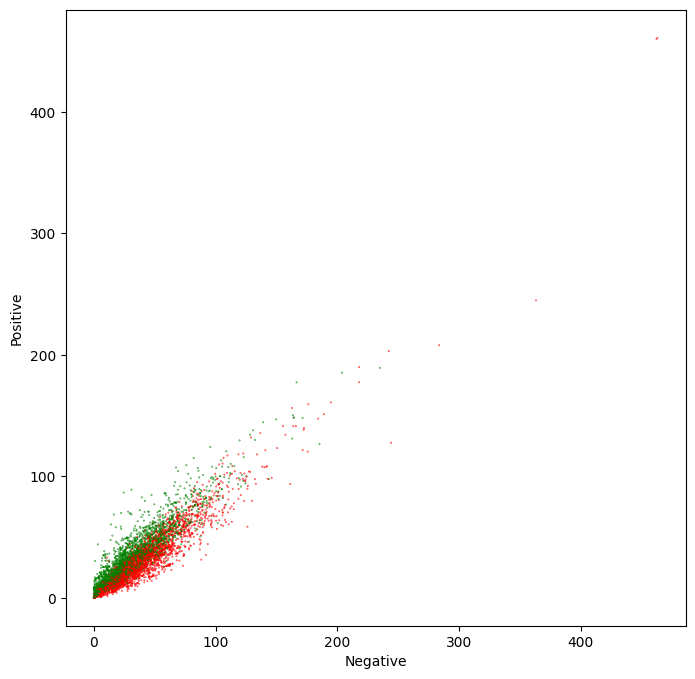

In [72]:
import matplotlib.pyplot as plt 
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(np.array(list(sentence_vectors.values()))[:,1], np.array(list(sentence_vectors.values()))[:,2], c=[colors[int(k)] for k in chosen_sentences_index_to_label.values()], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Negative")
plt.ylabel("Positive")

# Training the Logistic Regression Model

In [73]:
chosen_sentences_index_to_label

{3874: 1,
 3950: 1,
 17420: 1,
 20049: 0,
 20135: 0,
 20152: 0,
 20219: 0,
 20290: 0,
 20837: 0,
 20850: 1,
 30579: 0,
 34290: 1,
 47760: 0,
 49928: 1,
 60365: 1,
 68950: 1,
 83065: 1,
 83868: 1,
 84229: 1,
 84329: 1,
 84562: 1,
 84922: 1,
 86167: 1,
 87162: 1,
 88045: 1,
 89146: 1,
 101919: 1,
 103370: 1,
 104398: 1,
 104878: 1,
 105343: 1,
 105354: 1,
 105433: 1,
 107541: 1,
 109152: 1,
 109211: 1,
 110008: 0,
 115957: 0,
 116072: 0,
 127672: 1,
 128645: 1,
 142131: 1,
 142446: 1,
 142565: 0,
 142566: 0,
 144194: 1,
 147938: 1,
 147960: 1,
 148689: 1,
 150601: 1,
 151323: 1,
 157378: 1,
 159191: 1,
 162843: 1,
 179321: 1,
 187571: 0,
 194866: 0,
 194872: 0,
 195004: 0,
 195039: 0,
 195047: 0,
 195092: 0,
 198586: 1,
 199066: 1,
 200466: 1,
 204652: 1,
 228370: 1,
 228377: 1,
 263007: 1,
 263515: 1,
 270611: 1,
 294204: 1,
 312949: 1,
 316570: 1,
 318873: 1,
 373523: 1,
 373855: 1,
 378707: 1,
 382331: 1,
 385009: 1,
 385037: 1,
 385616: 1,
 386553: 1,
 389183: 1,
 392171: 1,
 399130:

In [74]:
sentence_vectors

{3874: [1, 0.0, 0.44910179640718556],
 3950: [1, 0.0746268656716418, 1.4221556886227555],
 17420: [1, 0.0, 0.18712574850299402],
 20049: [1, 0.9328358208955224, 0.0],
 20135: [1, 1.2686567164179106, 0.037425149700598806],
 20152: [1, 2.4626865671641793, 1.87125748502994],
 20219: [1, 0.7835820895522388, 0.0],
 20290: [1, 0.2611940298507463, 0.0],
 20837: [1, 3.9925373134328357, 5.127245508982036],
 20850: [1, 0.0, 0.2994011976047904],
 30579: [1, 0.2611940298507463, 0.037425149700598806],
 34290: [1, 0.0, 0.11227544910179642],
 47760: [1, 0.0746268656716418, 0.0],
 49928: [1, 14.701492537313435, 15.08233532934132],
 60365: [1, 7.798507462686568, 8.12125748502994],
 68950: [1, 2.3880597014925375, 1.7215568862275452],
 83065: [1, 6.67910447761194, 5.501497005988023],
 83868: [1, 0.8582089552238805, 1.4595808383233533],
 84229: [1, 1.007462686567164, 1.9461077844311379],
 84329: [1, 2.3507462686567164, 2.50748502994012],
 84562: [1, 22.014925373134332, 22.043413173652695],
 84922: [1, 1.9

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [76]:
X = np.array(list(sentence_vectors.values()))[:,1:3]
y = list(chosen_sentences_index_to_label.values())

In [77]:
# 80% training size and 20% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=200)

In [78]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [79]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       548
           1       0.71      0.78      0.74       523

    accuracy                           0.74      1071
   macro avg       0.74      0.74      0.74      1071
weighted avg       0.74      0.74      0.74      1071



# Naive-Bayes

In [80]:
df_naive = df.copy()

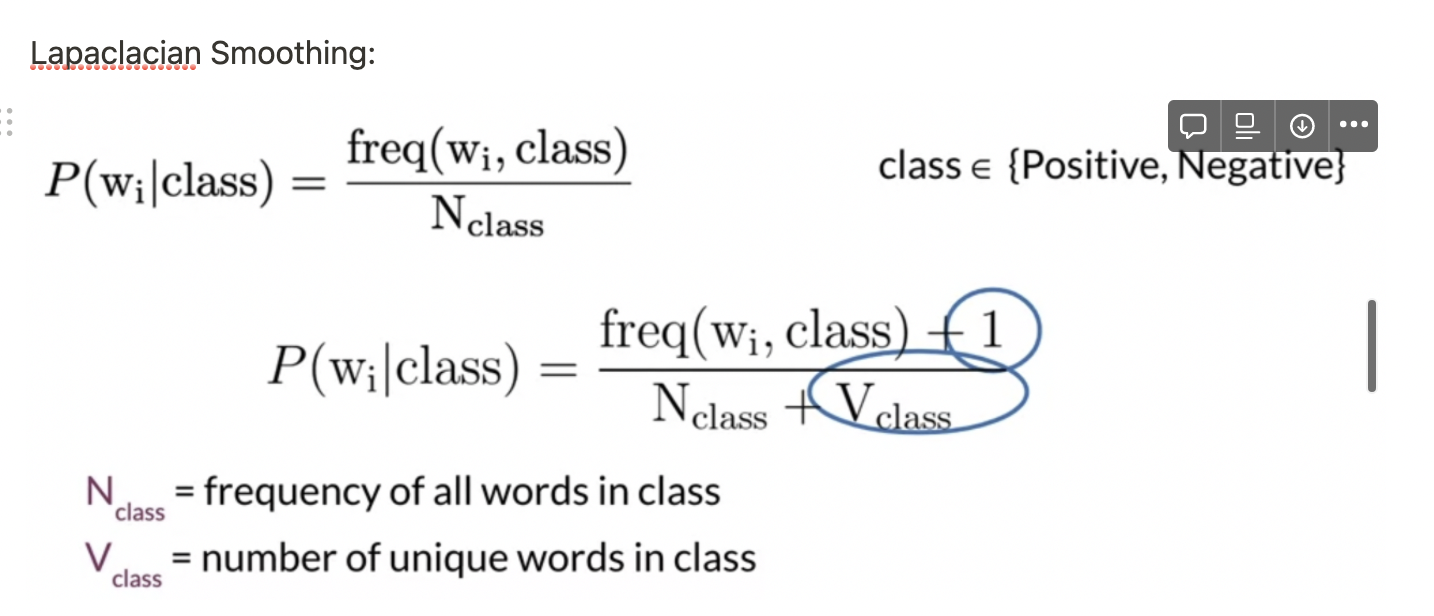

In [81]:
freq_table['growth']

[392, 298]

In [82]:
num_negative_words_counts = sum(np.array(list(freq_table.values()))[:,0])
num_positive_words_counts = len(np.array(list(freq_table.values()))[:,1])
print(num_negative_words_counts)
print(num_positive_words_counts)

34847
10193


In [83]:
V = len(set(freq_table.keys()))
V

10193

In [84]:
df_naive['Positive % Smoothed'] = (df_naive['Positive Sentences %'] + 1) / (num_positive_words_counts + V) 
df_naive['Negative % Smoothed'] = (df_naive['Negative Sentences %'] + 1) / (num_negative_words_counts + V) 
df_naive['Ratio'] = df_naive['Positive % Smoothed'] / df_naive['Negative % Smoothed']

In [85]:
df_naive.drop(['Negative Sentences %', 'Positive Sentences %'], axis=1, inplace=True)
df_naive

,Negative Sentences,Positive Sentences,Positive % Smoothed,Negative % Smoothed,Ratio
sensorii,0,1,0.000051,0.000022,2.292045
cavi,0,1,0.000051,0.000022,2.292045
sunt,0,1,0.000051,0.000022,2.292045
cerebri,0,1,0.000051,0.000022,2.292045
membranis,0,1,0.000051,0.000022,2.292045
...,...,...,...,...,...
sciences,0,1,0.000051,0.000022,2.292045
america,0,1,0.000051,0.000022,2.292045
tator,0,1,0.000051,0.000022,2.292045
shoichet,0,1,0.000051,0.000022,2.292045


In [86]:
df_naive.sort_values(by='Ratio', ascending=True)[0:20]

,Negative Sentences,Positive Sentences,Positive % Smoothed,Negative % Smoothed,Ratio
inhibition,245,26,0.000097,0.000225,0.429824
deletion,154,10,0.000067,0.000150,0.450058
myelin,285,61,0.000161,0.000258,0.623429
inhibitor,147,24,0.000093,0.000144,0.646687
mutant,107,13,0.000073,0.000111,0.657836
inhibitory,142,32,0.000108,0.000140,0.770865
receptor,352,112,0.000255,0.000314,0.811510
lar,60,6,0.000060,0.000072,0.835330
fyn,44,0,0.000049,0.000059,0.836311
2002,88,19,0.000084,0.000095,0.882529


In [87]:
df_naive.sort_values(by='Ratio', ascending=False)[0:20]

,Negative Sentences,Positive Sentences,Positive % Smoothed,Negative % Smoothed,Ratio
fgf,10,342,0.000677,0.000030,22.203098
gal,2,166,0.000354,0.000024,14.828561
label,5,114,0.000258,0.000026,9.806034
d15a,3,77,0.000190,0.000025,7.712780
lane,0,52,0.000145,0.000022,6.509011
green,1,54,0.000148,0.000023,6.434296
mpz,0,47,0.000135,0.000022,6.095583
section,12,80,0.000196,0.000032,6.095071
gfap,6,62,0.000163,0.000027,5.993940
stain,9,67,0.000172,0.000030,5.801148


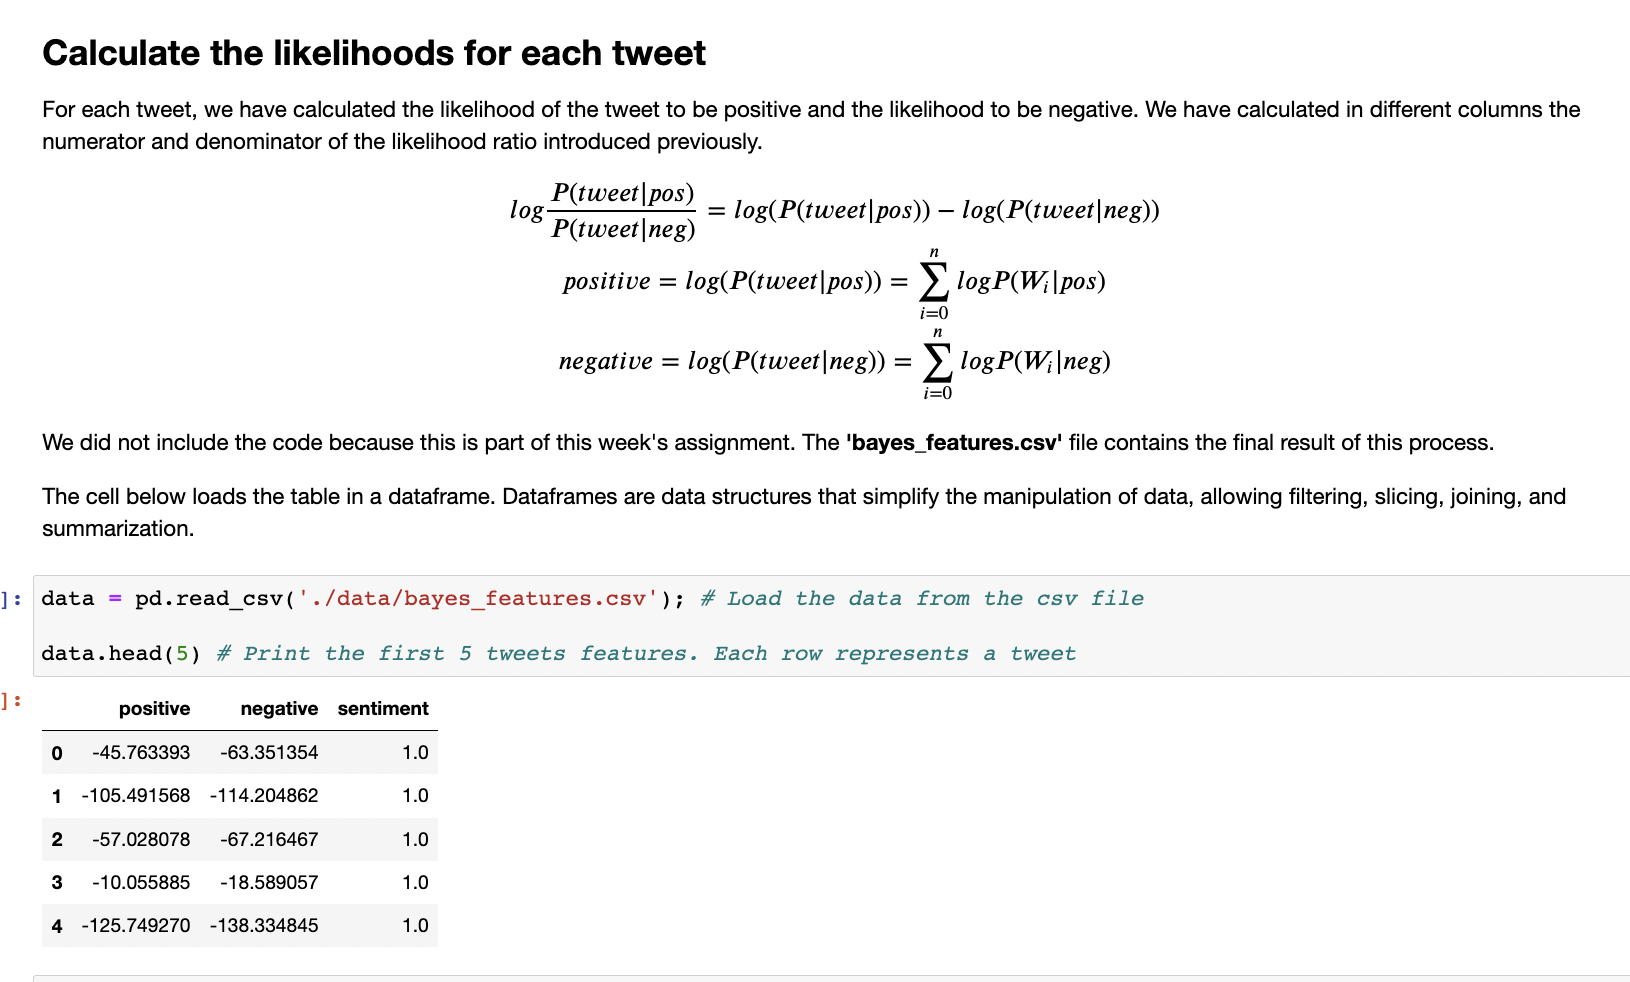

In [ ]:
import math
# Now that we have the frequency table in the form of % we need to 
# add up the all the log likelihoods for positive and negative word in each 
# sentence to create the log likelihood vector of the sentence 
sentence_log_likelihood_vectors = {} 
index = 0 
for sentence_index, sentence_class in chosen_sentences_index_to_label.items():
  proc_sentence = all_proc_docs_1D[sentence_index]
  negative_sum = 0 
  positive_sum = 0 
  for word in proc_sentence:
    # this should filter out specific molecules
    if word in df.index:
      negative_sum += math.log(df_naive.loc[word,'Negative % Smoothed'])
      positive_sum += math.log(df_naive.loc[word,'Positive % Smoothed'])
  
  sentence_log_likelihood_vectors[sentence_index] = [negative_sum, positive_sum]

sentence_log_likelihood_vectors

{20049: [-244.5684548310518, -223.1905843517377],
 20135: [-361.6402004610465, -329.86903371692813],
 20152: [-169.15613381827973, -154.254098854901],
 20219: [-191.35082025812866, -174.67089210135993],
 20290: [-74.45533538903896, -67.92756915052883],
 20837: [-126.07310437251294, -114.84698056834878],
 30579: [-63.78360675270955, -58.15875711481266],
 47760: [-21.272952968296845, -19.407876900151095],
 109211: [-168.60008391091353, -151.7778681540358],
 110008: [-94.6056466991389, -85.45745337932149],
 115957: [-166.17835795282386, -150.7541828746717],
 116072: [-79.8047195015801, -72.34914551754254],
 142565: [-61.232143491688646, -55.73717406610676],
 142566: [-30.747458622995353, -28.309825593702165],
 147938: [-63.857975857127926, -57.34695049554172],
 147960: [-117.00596207433298, -105.74464526328214],
 151323: [-32.019050709044635, -28.917194593304774],
 162843: [-179.58390308252777, -161.57214743402935],
 187571: [-31.38644578802684, -28.98602159082418],
 194866: [-93.80714870

(-400.0, 0.0)

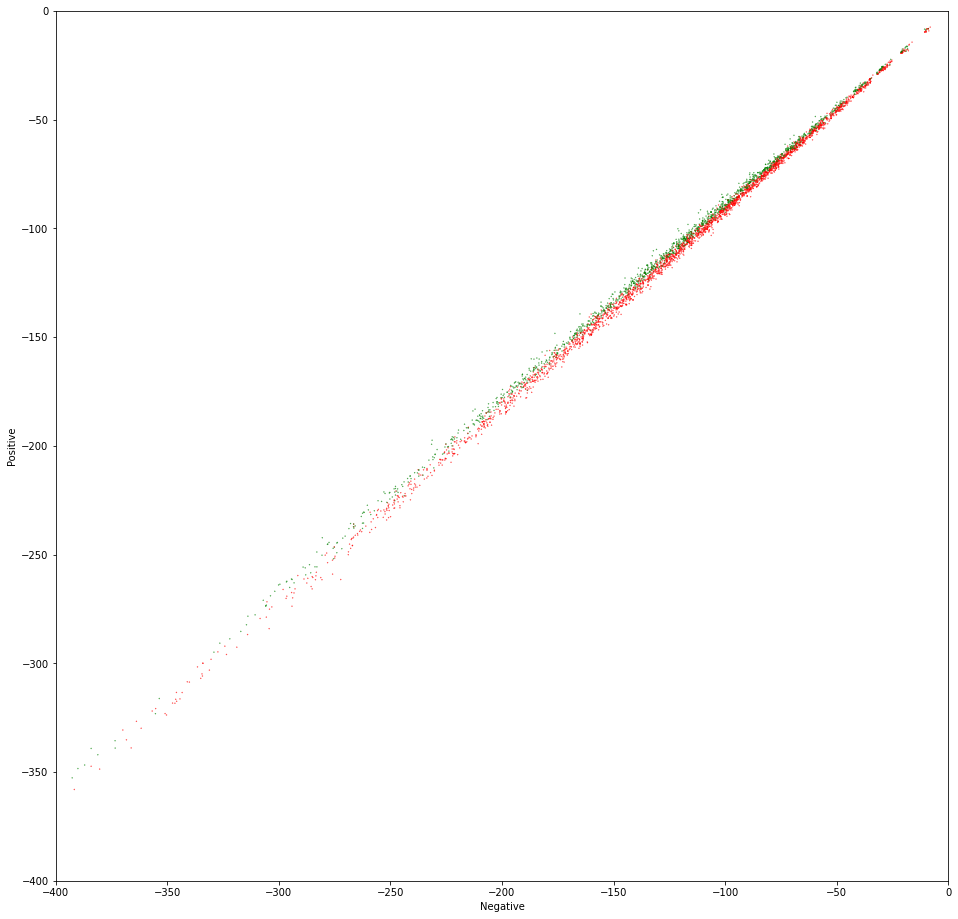

In [ ]:
import matplotlib.pyplot as plt 
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (16, 16))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(np.array(list(sentence_log_likelihood_vectors.values()))[:,0], np.array(list(sentence_log_likelihood_vectors.values()))[:,1], c=[colors[int(k)] for k in chosen_sentences_index_to_label.values()], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Negative")
plt.ylabel("Positive")
plt.xlim(-400,0)
plt.ylim(-400,0)

In [ ]:
one_arr = [] 
for index in chosen_sentences_index_to_label.keys(): 
  proc_sentence = all_proc_docs_1D[index]
  # filter out specific molecules
  filtered_sentence = [word for word in proc_sentence if word not in orig_molecules]
  one_arr.append(' '.join(filtered_sentence))

In [ ]:
one_arr[200] # used to have mag in here 

'dysregulate myelination encounter mutant sample'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(one_arr)

In [ ]:
one_arr[200]

'dysregulate myelination encounter mutant sample'

In [ ]:
X[200]

<1x8185 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [ ]:
len(vectorizer.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


8185

In [ ]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
len(X.toarray()[0])

8185

In [ ]:
y = list(chosen_sentences_index_to_label.values())
len(X.toarray()) == len(y)

True

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=200)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB()

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       539
           1       0.71      0.68      0.69       297

    accuracy                           0.79       836
   macro avg       0.77      0.76      0.76       836
weighted avg       0.78      0.79      0.78       836



In [ ]:
vectorizer.vocabulary_

8185

In [ ]:
neg_sentence = ['myelin']
pos_sentence = ['cytokine']

def sentence_to_naive_vec(sentence, vectorizer):
  word2index = vectorizer.vocabulary_
  naive_vec = np.zeros(len(word2index))
  for word in sentence:
    naive_vec[word2index[word]] = 1 

  return naive_vec 

s = sentence_to_naive_vec(neg_sentence, vectorizer)
s2 = sentence_to_naive_vec(pos_sentence, vectorizer)

print(s)
assert s[vectorizer.vocabulary_[neg_sentence[0]]] == 1
assert s[vectorizer.vocabulary_[neg_sentence[0]]+ 1] == 0

# has to be 2D array
print(clf.predict_proba([s]))
print(clf.predict_proba([s2]))

[0. 0. 0. ... 0. 0. 0.]
[[0.86160594 0.13839406]]
[[0.30370144 0.69629856]]
